# Lab 05: Accelerometer

## Data acquisition notebook

We're going to use an accelerometer to measure the height of the physics building. The accelerometer speaks a communication protocol called SPI, which the Raspberry Pi knows how to talk. This requires adding some extra wires to your circuit. And then the provided `ADXL362` module contains the python code to read acceleration data.

This notebook is meant to be run in its entirety, use the ">>" button (or the menu: Kernel -> Restart and Run All) to restart the kernel and re-run the whole notebook.

When run, it will wait for the push button to be pressed. Then it will record data from the accelerometer until the button is pressed again, at which point it will stop.

# Assignment

1. Disconnect the rainbow ribbon cable from your breadboard. Connect the accelerometer to the SPI channels of the Raspberry Pi, as shown here. (Higher resolution photo on canvas)
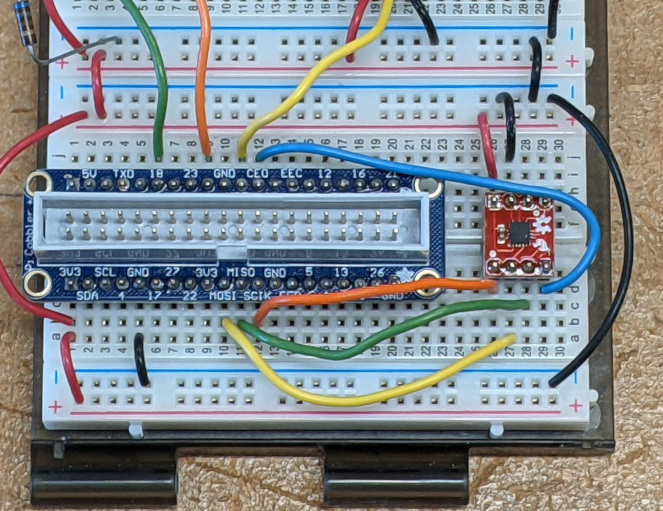
2. Have an instructor check breadboard, and then reconnect ribbon cable
3. write a function called `new_data_file`, which will:
   * Pick a file name with the current date/time in its name (see `time.strftime` from last week)
   * `open` the new file
   * update a symbolic link to the file, which has a constant name
   * `return` the file object
4. Create an `ADXL362` object, and run its `begin_measure` method. Then define a callback function named `record_data`. This will read the accelerometer and write its data (time, x, y, z) to a new line of the file object `f`. It will be called by `signal.SIGALRM` alarm/timer signals.
5. You should now be able to run the entire  notebook at once (">>" button in the toolbar, or menu: Kernel -> Restart and Run All). Do a short test run. Inspect data file and symlink.
6. Acquire around two minutes of data with the accelerometer stationary on the desk. Try not to touch or move your desk much while acquiring.

Finally, as preparation for next week, plug in the battery pack beneath the breadboard and confirm that it's working.

In [1]:
import signal
import time
import os
import gpiozero as io
from ADXL362 import ADXL362

### Do question 3 here

In [2]:
# copied exactly from the demo
def update_symlink(src, dest):
    """
    Update a symlink pointing to src from dest, or create it if dest doesn't exist
    """
    # create link at a temporary path and then move it to dest
    # this both avoids issues with existing files, and makes the link update more "atomic"
    import time
    # make a random temporary file name for the link, which is unlikely to exist
    tmplink = f"tmplink{time.time()}"
    os.symlink(src, tmplink)
    # move the temporary link to the desired destination
    os.replace(tmplink, dest)

In [3]:
def new_data_file():
    # I use the string format method here rather than f-strings, because I can
    # format the same string twice, to get link and file names.
    filename = "accelerometer_data_{}.txt"
    linkname = filename.format("latest")
    filename = filename.format(time.strftime("%Y%m%d%H%M%S"))
    f = open(filename, "w")
    update_symlink(filename, linkname)
    return f

### Do question 4 here

In [4]:
accel = ADXL362()
accel.begin_measure()

In [5]:
def record_data(signum, frame):
    """callback function to record data in response to SIGALRM timer"""
    t, ax, ay, az = accel.read_txyz()
    f.write(f"{t} {ax} {ay} {az}\n")

### Do the data acquisition

This part needs to be after your solutions to questions 3 nd 4

In [6]:
# create an LED object and turn it off to start
led = io.LED(18)
led.off()

In [7]:
# Create a button then wait for it to be pressed
#
# the `bounce time` argument is used because sometimes mechanical switches can appear to flicker
# rapidly on and off when pressed/released.
# A simple way to avoid theses "bounces" is to wait a short time after any change before recognizing another
# Setting bounce_time=0.01 will ignore any repeated presses/releases within 0.01 seconds of each other.
button = io.Button(24, bounce_time=0.01)
# wait_for_press method will pauses execution until the button is pressed
button.wait_for_press()
# next, wait for release, to avoid measuring extra acceleration from pressing/releasing the button
button.wait_for_release()
# finally, turn the LED on to indicate that measurement has started
led.on()

In [8]:
# specify the interval between readouts, in seconds
readout_interval = 0.01

try:
    # create data file using function defined in question 3
    f = new_data_file()
    
    # bind the function from question 4 to signal.SIGALRM
    signal.signal(signal.SIGALRM, record_data)
    # starting the timer after 0.5 seconds, repeating at readout_interval
    signal.setitimer(signal.ITIMER_REAL, 0.5, readout_interval)
    
    # wait for another button press before ending
    button.wait_for_press()
# there is no except block here
finally:
    # start clean-up by disabling the SIGALRM timer
    signal.setitimer(signal.ITIMER_REAL, 0.0, 0.0)
    # turn the LED off
    led.off()
    # close the data file
    f.close()